In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
# Download stock price data
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402176,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714725,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716957,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049517,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973555,237458000
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


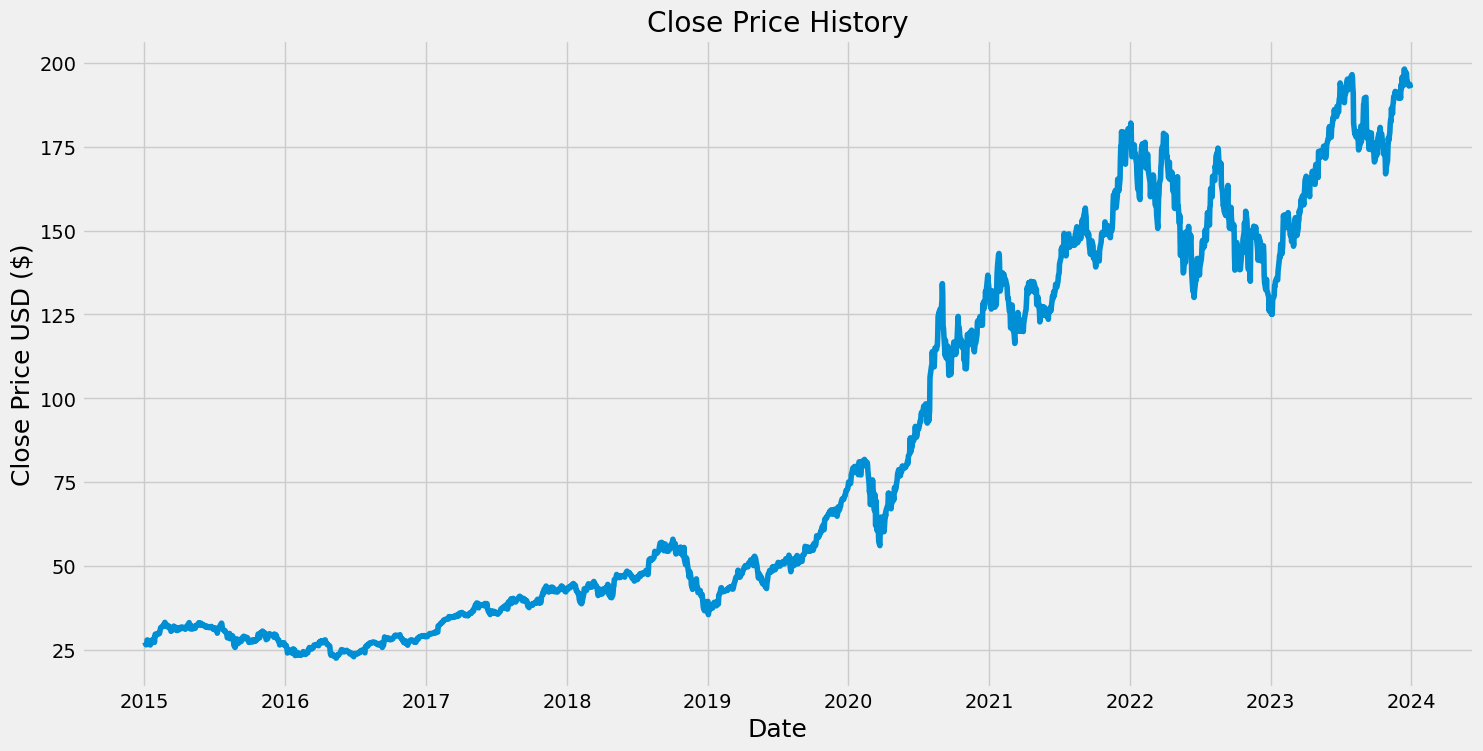

In [4]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
# Create the training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()


[array([0.02704744, 0.02266059, 0.02267484, 0.02479704, 0.03069364,
       0.03086456, 0.02693349, 0.02831506, 0.02771686, 0.02347244,
       0.02229027, 0.02617861, 0.02736078, 0.03142003, 0.03224613,
       0.03241704, 0.02677682, 0.03556474, 0.04067797, 0.0381997 ,
       0.04029341, 0.0403219 , 0.041618  , 0.04215924, 0.0407207 ,
       0.0418459 , 0.04512178, 0.04919527, 0.05144567, 0.05232874,
       0.05339696, 0.05466458, 0.05428002, 0.05577554, 0.06076058,
       0.05957841, 0.05476427, 0.05708589, 0.05429427, 0.05519157,
       0.05557613, 0.0544082 , 0.05137446, 0.05164507, 0.05241419,
       0.04866829, 0.04543512, 0.04858282, 0.04735793, 0.04929497,
       0.05227176, 0.05430851, 0.05292694, 0.05064806, 0.05251389,
       0.05177326, 0.04705882, 0.04828372, 0.04687367, 0.05131748])]
[0.04855434221753735]



In [7]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\DELL\anaconda31\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


1752/1752 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - loss: 0.0036


In [9]:
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'RMSE: {rmse}')

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
RMSE: 5.634015492773396


C:\Users\DELL\AppData\Local\Temp\ipykernel_21012\2357466549.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


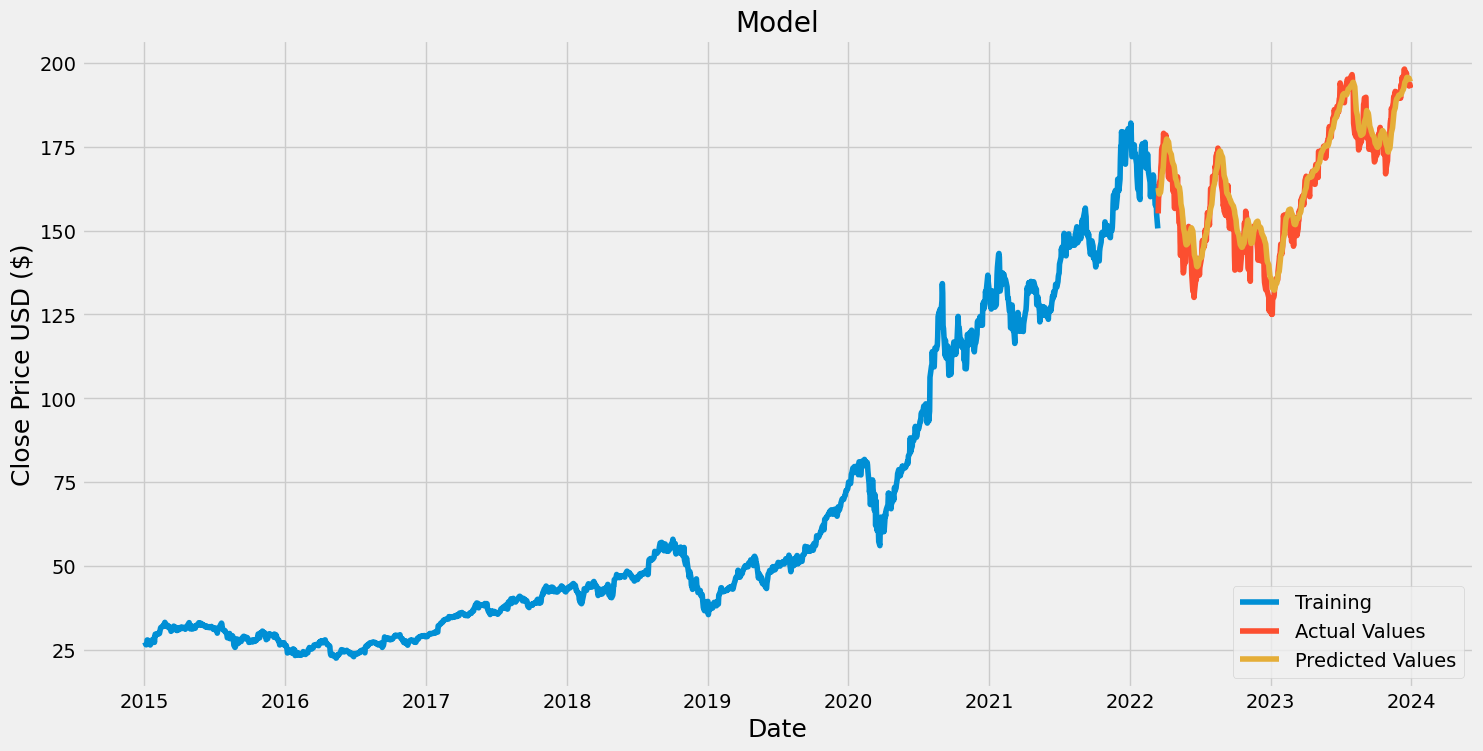

In [17]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training', 'Actual Values', 'Predicted Values'], loc='lower right')
plt.show()


In [18]:
# Predict the next 30 days
new_df = data[-60:].values
new_df = scaler.transform(new_df)
new_df = np.array(new_df)
new_df = np.reshape(new_df, (1, new_df.shape[0], 1))

predictions_30_days = []
for _ in range(30):
    pred = model.predict(new_df)
    predictions_30_days.append(pred[0, 0])
    new_df = np.append(new_df[:, 1:, :], np.reshape(pred, (1, 1, 1)), axis=1)

predictions_30_days = scaler.inverse_transform(np.array(predictions_30_days).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

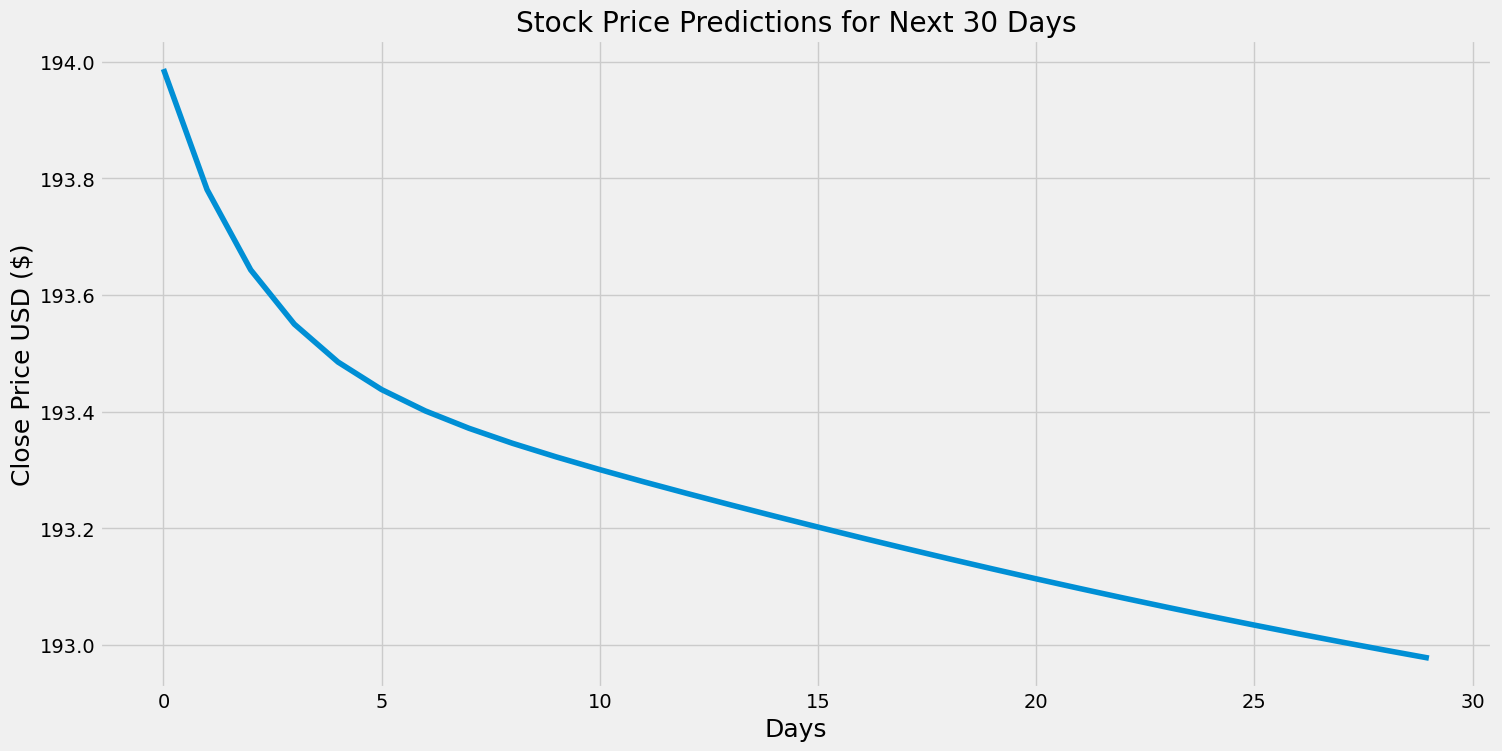

In [19]:
# Plot the next 30 days predictions
plt.figure(figsize=(16,8))
plt.title('Stock Price Predictions for Next 30 Days')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(predictions_30_days)
plt.show()


In [13]:
# Download stock price data for January 2024
new = yf.download('AAPL', start='2024-01-01', end='2024-01-31')
new

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.152283,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.765930,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.432098,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.703995,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,185.072495,59144500
2024-01-09,183.919998,185.149994,182.729996,185.139999,184.653595,42841800
2024-01-10,184.350006,186.399994,183.919998,186.190002,185.700851,46792900
2024-01-11,186.539993,187.050003,183.619995,185.589996,185.102417,49128400
2024-01-12,186.059998,186.740005,185.190002,185.919998,185.431549,40444700


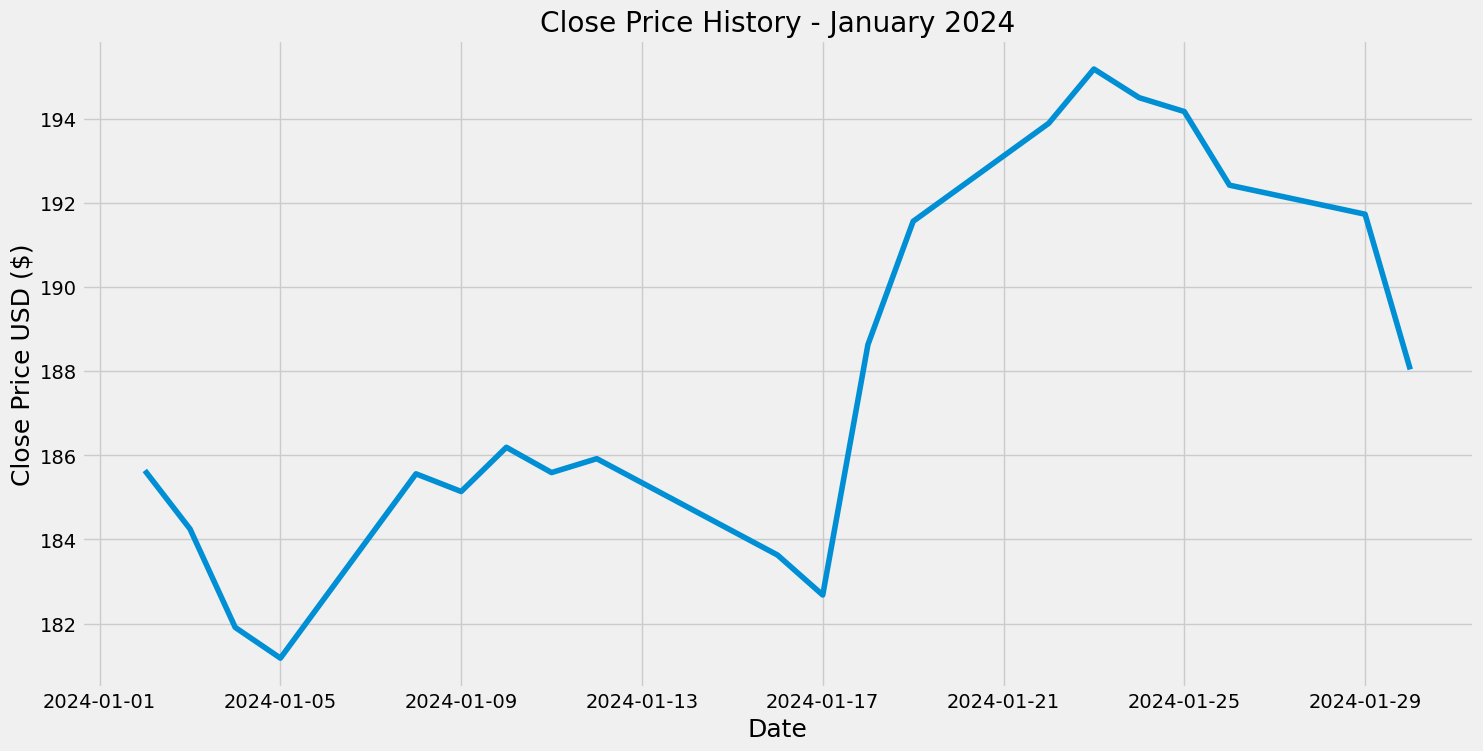

In [14]:
# Visualize the closing price history for January 2024
plt.figure(figsize=(16,8))
plt.title('Close Price History - January 2024')
plt.plot(new['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [15]:
# Compare the predicted stock prices for the next 30 days with the actual stock prices for January 2024
actual_30_days = new['Close'].values[:30]
days = range(1, len(actual_30_days) + 1)

# Create a bar graph comparing the predicted and actual stock prices
pred_days = range(1, 31)

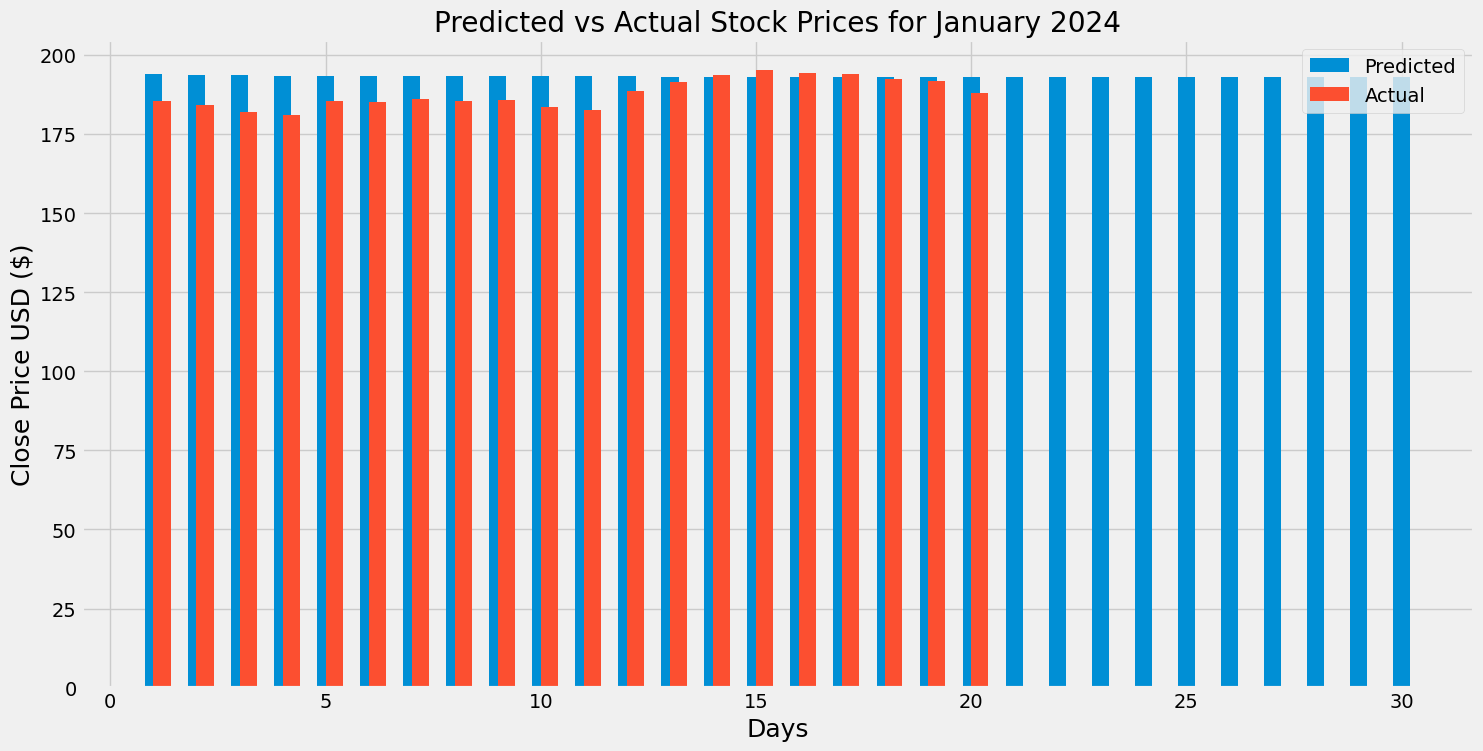

In [16]:
plt.figure(figsize=(16,8))
plt.title('Predicted vs Actual Stock Prices for January 2024')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.bar(pred_days, predictions_30_days.flatten(), width=0.4, label='Predicted', align='center')
plt.bar(days, actual_30_days, width=0.4, label='Actual', align='edge')
plt.legend(loc='upper right')
plt.show()